In [19]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [20]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

num_train, img_rows, img_cols, img_channels =  train_x.shape
num_test, _, _, _ =  test_x.shape
num_classes = len(np.unique(train_y))
print(num_train, num_test, num_classes, img_rows, img_cols, img_channels)

50000 10000 10 32 32 3


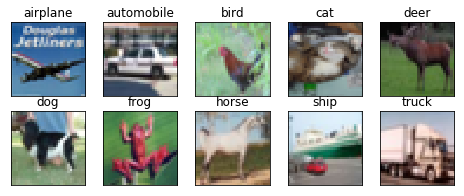

In [21]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_y[:]==i)[0]
    features_idx = train_x[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [22]:
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255
# convert class y to binary class y
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)

In [100]:
class cnnmodel:
    def __init__(self, loss_fn, name="soft"):
        _IMAGE_SIZE = 32
        _IMAGE_CHANNELS = 3
        _NUM_CLASSES = 10
        tf.reset_default_graph()
        self.loss_name = name
        with tf.name_scope('main_params'):
            self.x_ph = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='Input')
            self.y_ph = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
            self.x_image = self.x_ph
            self.drp_rate = tf.placeholder(tf.float32)

            self.global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
            self.learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
#             self.learning_rate = 0.001

        with tf.variable_scope('conv1') as scope:
            conv = tf.layers.conv2d(
                inputs=self.x_image,
                filters=32,
                kernel_size=[3, 3],
                padding='SAME',
                activation=tf.nn.relu
            )
            conv = tf.layers.conv2d(
                inputs=conv,
                filters=64,
                kernel_size=[3, 3],
                padding='SAME',
                activation=tf.nn.relu
            )
            pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
            drop = tf.layers.dropout(pool, rate=self.drp_rate, name=scope.name)

        with tf.variable_scope('conv2') as scope:
            conv = tf.layers.conv2d(
                inputs=drop,
                filters=128,
                kernel_size=[3, 3],
                padding='SAME',
                activation=tf.nn.relu
            )
            pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
            conv = tf.layers.conv2d(
                inputs=pool,
                filters=128,
                kernel_size=[2, 2],
                padding='SAME',
                activation=tf.nn.relu
            )
            pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
            drop = tf.layers.dropout(pool, rate=self.drp_rate, name=scope.name)

        with tf.variable_scope('fully_connected') as scope:
            flat = tf.reshape(drop, [-1, 4 * 4 * 128])

            self.fc_ = tf.layers.dense(inputs=flat, units=1500, activation=tf.nn.relu)
            self.fc = tf.layers.dropout(self.fc_, rate=self.drp_rate)
            self.W1 = tf.Variable(tf.random_normal((1500, _NUM_CLASSES), stddev = np.sqrt(1)))
            self.logits_ = tf.matmul(self.fc, self.W1)
            
        self.loss, self.logits = loss_fn(self.logits_, self.y_ph, self.fc, self.W1)
        self.optimizer_ = tf.train.AdamOptimizer(learning_rate=self.learning_rate,
                                       epsilon=1e-08)
        self.optimizer = self.optimizer_.minimize(self.loss)
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        print("Initialization of model completed")
        
        self.dir_path = "./../saved/models/"

    def train_step(self, x, y, lr = 0.001):
        loss, _ = self.sess.run([self.loss, self.optimizer],\
                                feed_dict={self.x_ph : x, self.y_ph : y, self.drp_rate : 0.5,\
                                           self.learning_rate : lr})
        return y
    
    def predict(self, x, y):
        y_pred = self.sess.run([self.logits], feed_dict={self.x_ph : x, self.y_ph : y, self.drp_rate:0.0})
        return y_pred

    def get_logits(self, x, y):
        logits_old, logits_new = \
        self.sess.run([self.logits_, self.logits], feed_dict={self.x_ph : x, self.y_ph : y, self.drp_rate:0.0})
        return logits_old, logits_new
        
    def get_loss(self, x, y):
        loss = self.sess.run(self.loss, feed_dict={self.x_ph : x, self.y_ph : y, self.drp_rate : 0.0})
        return loss

    def get_repre(self, x):
        repre = self.sess.run([self.fc], feed_dict={self.x_ph : x, self.drp_rate:0.0})
        return repre

    def get_best(self):
        all_files = os.listdir(self.dir_path)
        best = [0, ""]
        for file in all_files:
            def checker(f):
                return ("meta" in file) and ("cifar10" in file) and ("cnn" in file) and (self.loss_name in file)
            if checker(file):
                acc = int(file.split(".")[1])
                if acc > best[0]:
                    best = [acc, file]
        return best

    def model_saver(self, acc):
        best = self.get_best()
        if "meta" in best[1]:
            acc_ = int(best[1].split(".")[1]) * 1.0 / 10000
        else:
            acc_ = 0
        if acc_ > acc:
            return
        print("Saving model with accuracy : {}".format(acc))
        self.saver.save(self.sess, os.path.join(self.dir_path, "cifar10_cnn_"+ self.loss_name\
                                                +"_{0:.4f}".format(acc)))
        
    def model_restorer(self):
        best = self.get_best()
        print("Found best model with acc : {} {}. Restoring...".format(best[0], best[1]))
        self.saver.restore(self.sess, os.path.join(self.dir_path, best[1][:-5]))
        self.sess.run(tf.variables_initializer(optimizer.variables()))


        

In [24]:
# define the usual softmax and the loss function
def get_loss_softmax(logits, y_ph, fc, w1):
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_ph)
    return loss, logits

In [25]:
# define the varied softmax and the loss function

In [26]:
def accuracy(y_pred, y_orig):
    y_pred = np.array(y_pred[0])
    correct = (np.argmax(y_pred, axis=1) == np.argmax(y_orig, axis=1))
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [95]:
_BATCH_SIZE = 16
_EPOCH = 60

def test(model, ep, j):
    test_batch_size = 1000
    test_n_batches = len(test_y) // test_batch_size
    accs = []
    for i in range(test_n_batches):
        test_x_batch = test_x[i * test_batch_size : (i + 1) * test_batch_size]
        test_y_batch = test_y[i * test_batch_size : (i + 1) * test_batch_size]
        y_pred = model.predict(test_x_batch, test_y_batch)
        accs.append(accuracy(y_pred, test_y_batch))
    accu = sum(accs) / len(accs)
    print("Model accuracy after epoch {} batch no {} is : {}".format(ep, j, accu))
    return accu
    
def train(model):
    n_batches = len(train_x) // _BATCH_SIZE
    lrs = [0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.00001]
    best_accu = 0
    for i in range(_EPOCH):
        print("Running epoch : {}".format(i + 1))
        for j in range(n_batches):
            train_x_batch = train_x[j * _BATCH_SIZE : (j + 1) * _BATCH_SIZE]
            train_y_batch = train_y[j * _BATCH_SIZE : (j + 1) * _BATCH_SIZE]
            model.train_step(train_x_batch, train_y_batch, lrs[i // 10])
            if j%100 == 0:
                accu = test(model, i, j)
                if accu > best_accu:
                    best_accu = accu
                    model.model_saver(best_accu)
                    

In [10]:
model = cnnmodel(get_loss_softmax)
train(model)


Initialization of model completed
Running epoch : 1
Model accuracy after epoch 0 batch no 0 is : 0.1004
Model accuracy after epoch 0 batch no 100 is : 0.4427
Model accuracy after epoch 0 batch no 200 is : 0.5109
Model accuracy after epoch 0 batch no 300 is : 0.568
Running epoch : 2
Model accuracy after epoch 1 batch no 0 is : 0.6305000000000001
Model accuracy after epoch 1 batch no 100 is : 0.6525000000000001
Model accuracy after epoch 1 batch no 200 is : 0.6941999999999999
Model accuracy after epoch 1 batch no 300 is : 0.7054
Running epoch : 3
Model accuracy after epoch 2 batch no 0 is : 0.7160999999999998
Model accuracy after epoch 2 batch no 100 is : 0.7205999999999999
Model accuracy after epoch 2 batch no 200 is : 0.7356
Model accuracy after epoch 2 batch no 300 is : 0.7168
Running epoch : 4
Model accuracy after epoch 3 batch no 0 is : 0.7402
Model accuracy after epoch 3 batch no 100 is : 0.7417
Model accuracy after epoch 3 batch no 200 is : 0.749
Model accuracy after epoch 3 batch

Model accuracy after epoch 31 batch no 200 is : 0.796
Model accuracy after epoch 31 batch no 300 is : 0.7959
Running epoch : 33
Model accuracy after epoch 32 batch no 0 is : 0.7961
Model accuracy after epoch 32 batch no 100 is : 0.7959
Model accuracy after epoch 32 batch no 200 is : 0.7958000000000001
Model accuracy after epoch 32 batch no 300 is : 0.7955999999999999
Running epoch : 34
Model accuracy after epoch 33 batch no 0 is : 0.7963000000000001
Model accuracy after epoch 33 batch no 100 is : 0.796
Model accuracy after epoch 33 batch no 200 is : 0.7958
Model accuracy after epoch 33 batch no 300 is : 0.7958999999999999
Running epoch : 35
Model accuracy after epoch 34 batch no 0 is : 0.7964
Model accuracy after epoch 34 batch no 100 is : 0.7962
Model accuracy after epoch 34 batch no 200 is : 0.7957
Model accuracy after epoch 34 batch no 300 is : 0.7961
Running epoch : 36
Model accuracy after epoch 35 batch no 0 is : 0.7968
Model accuracy after epoch 35 batch no 100 is : 0.7963
Model 

In [11]:
repre = model.get_repre(train_x[:1000])
repre = np.array(repre[0])

In [12]:
from sklearn.decomposition import PCA
pca_algo = PCA(n_components=2)
fitted_repre = pca_algo.fit_transform(repre)

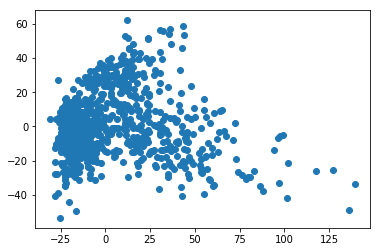

In [13]:
plt.scatter(fitted_repre[:, 0], fitted_repre[:, 1])

In [14]:
fitted_repre_scaled = (fitted_repre - np.mean(fitted_repre, axis = 0)) / np.std(fitted_repre, axis = 0)

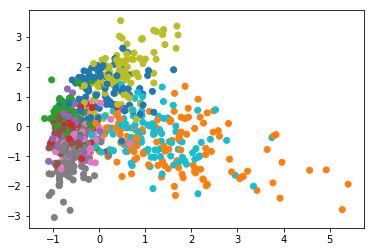

In [15]:
plt.scatter(fitted_repre_scaled[:, 0], fitted_repre_scaled[:, 1], c=["C" + str(int(k)) for k in np.argmax(train_y[:1000], axis = 1)])

In [102]:
m = 4
def get_loss_l_softmax(logits, y_ph, fc, w1):
    import math
    pi = math.pi
    def square_sum(x, axis):
        return tf.reduce_sum(tf.multiply(x, x), axis = axis, keepdims=True)
    norms = tf.matmul(square_sum(fc, axis = 1), square_sum(w1, axis = 0))
    theeta = tf.acos(tf.divide(logits, norms))
    cond = {}
    res = {}
    new_logits = theeta * 0
    for i in range(m):
        cond[i] = tf.cast(
            tf.math.logical_and(tf.math.less_equal(theeta, (i+1)*pi/m), tf.math.greater_equal(theeta, i*pi/m)),
            tf.float32)
        res[i] = tf.multiply(cond[i], tf.multiply(tf.cos(m*theeta-i*pi) - 2.0 * i, norms) )
        new_logits += res[i]
    new_logits = logits * (1 - y_ph) + new_logits * y_ph
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=new_logits, labels=y_ph)
    return loss, new_logits

In [103]:
model = cnnmodel(get_loss_l_softmax, "lsoft")
print(model.get_logits(train_x[:5], train_y[:5]), train_y[:5])
train(model)

Initialization of model completed
(array([[-1.1633953 ,  0.9838121 , -0.11937562,  0.871413  ,  0.982819  ,
         0.60231054, -0.9954467 , -1.13547   ,  0.00629866, -0.79992825],
       [-1.7052646 ,  1.455653  ,  0.36704263,  0.32388234, -0.01134628,
         1.0851741 , -1.0187192 , -1.0012429 , -0.2971601 , -0.25575936],
       [-2.6493146 ,  1.9228098 ,  0.19388771, -0.62893844,  0.01316071,
         3.0491438 , -0.49164104,  0.36002153, -1.1173897 ,  0.11049223],
       [-0.8748057 ,  0.51571435,  0.09618326,  0.4879505 ,  0.20805758,
         0.49345005, -0.6999555 , -0.83219004, -0.23414704, -0.36824593],
       [-2.1896648 ,  1.5164547 ,  0.6263645 , -0.12266272, -0.35257614,
         1.9278915 , -0.48666155, -0.31530833, -1.1783298 , -0.29208088]],
      dtype=float32), array([[-1.1633953e+00,  9.8381209e-01, -1.1937562e-01,  8.7141299e-01,
         9.8281902e-01,  6.0231054e-01, -1.4014343e+04, -1.1354700e+00,
         6.2986612e-03, -7.9992825e-01],
       [-1.7052646e+00

KeyboardInterrupt: 